<a href="https://colab.research.google.com/github/SaumilShah-7/Airbus-Ship-Detection-Challenge-Kaggle/blob/master/Airbus_Ship_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import 
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.measure import label

TensorFlow 2.x selected.
2.0.0


In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 122kB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [3]:
!kaggle competitions download -c airbus-ship-detection

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 81.3MB/s]
 50% 9.00M/18.0M [00:00<00:00, 28.8MB/s]
100% 18.0M/18.0M [00:00<00:00, 51.7MB/s]
100% 2.11G/2.12G [00:35<00:00, 37.3MB/s]
100% 2.12G/2.12G [00:35<00:00, 64.0MB/s]
100% 26.4G/26.4G [06:15<00:00, 61.4MB/s]
100% 26.4G/26.4G [06:15<00:00, 75.4MB/s]


In [0]:
!unzip -q train_v2.zip -d train
!unzip -q train_ship_segmentations_v2.csv.zip -d train_ship_segmentations
!unzip -q test_v2.zip -d test

!rm -rf train_v2.zip
!rm -rf train_ship_segmentations_v2.csv.zip
!rm -rf test_v2.zip

192556 192556
     Count     Count
0   150000  0.778994
1    27104  0.140759
2     7674  0.039853
3     2954  0.015341
4     1622  0.008424
5      925  0.004804
6      657  0.003412
7      406  0.002108
8      318  0.001651
9      243  0.001262
10     168  0.000872
11     144  0.000748
12     124  0.000644
14      76  0.000395
13      75  0.000389
15      66  0.000343


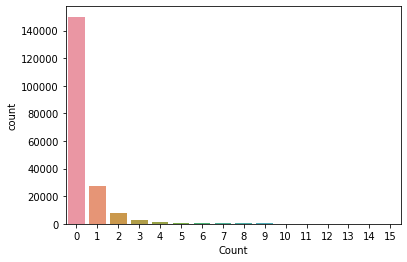

In [7]:
df = pd.read_csv('train_ship_segmentations/train_ship_segmentations_v2.csv')

print(len(df['ImageId'].unique()), len([name for name in os.listdir('train')]))

df['Count'] = df['EncodedPixels'].notnull()*1
df_h = df.groupby(['ImageId'])['Count'].sum()

print(pd.concat([df_h.value_counts(), df_h.value_counts(normalize=True)], axis=1))
sns.countplot(df_h)

192556
191289
    Shipnum   Shipnum
0    149293  0.780458
1     26737  0.139773
2      7563  0.039537
3      2908  0.015202
4      1608  0.008406
5       917  0.004794
6       652  0.003408
7       405  0.002117
8       314  0.001641
9       241  0.001260
10      168  0.000878
11      144  0.000753
12      122  0.000638
14       76  0.000397
13       75  0.000392
15       66  0.000345


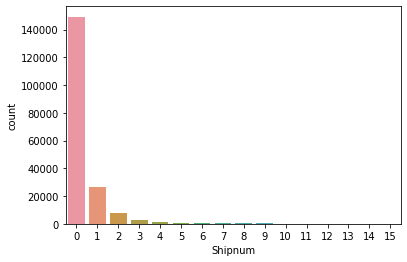

In [8]:
df_u = pd.DataFrame({'ImageId': df_h.index, 'Shipnum': df_h.values})
df_u['Filesize'] = df_u['ImageId'].apply(lambda x: os.path.getsize('train/'+x)/1024)

print(df_u.shape[0])
df_u = df_u[df_u['Filesize'] > 50]
print(df_u.shape[0])

print(pd.concat([df_u['Shipnum'].value_counts(), df_u['Shipnum'].value_counts(normalize=True)], axis=1))
sns.countplot(df_u['Shipnum'])

# import shutil
# os.makedirs('50-60')
# for index, row in df_u.iterrows():
#   if row['Filesize'] < 60 and row['Filesize'] >= 50:
#     shutil.copy('train/'+row['ImageId'], '50-60')
#   else:
#     pass
  
# !zip -r 50-60.zip 50-60
# !rm -rf 50-60

In [9]:
train_df, test_df = train_test_split(df_u, test_size=0.2, stratify=df_u['Shipnum'], random_state=7)
print(train_df.shape[0], test_df.shape[0])

153031 38258


In [10]:
print(train_df['Shipnum'].value_counts().median(), train_df['Shipnum'].value_counts().mean(), np.quantile(train_df['Shipnum'].value_counts(), 0.75))
print(train_df['Shipnum'].max())

287.5 9564.4375 1546.0
15


1500 8331
****************************************************************************************************
    Shipnum   Shipnum
3      1500  0.152579
2      1500  0.152579
1      1500  0.152579
0      1500  0.152579
4      1286  0.130811
5       734  0.074662
6       522  0.053097
7       324  0.032957
8       251  0.025531
9       193  0.019632
10      134  0.013630
11      115  0.011698
12       98  0.009968
14       61  0.006205
13       60  0.006103
15       53  0.005391


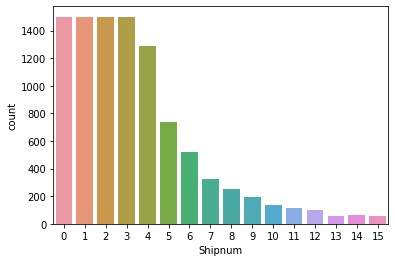

In [11]:
cutoff = 1500

balanced_train_df = pd.DataFrame(columns = train_df.columns)

for i in range(0, 16):
  if train_df[train_df['Shipnum']==i].shape[0] > cutoff:
    balanced_train_df = balanced_train_df.append(train_df[train_df['Shipnum']==i].sample(cutoff, random_state=7))
  else:
    balanced_train_df = balanced_train_df.append(train_df[train_df['Shipnum']==i])
    
print(balanced_train_df[balanced_train_df['Shipnum']==0].shape[0], balanced_train_df[balanced_train_df['Shipnum']>0].shape[0])
print('*'*100)
print(pd.concat([balanced_train_df['Shipnum'].value_counts(), balanced_train_df['Shipnum'].value_counts(normalize=True)], axis=1))
sns.countplot(balanced_train_df['Shipnum'])

In [0]:
image_height = 768
image_width = 768

def rle_decode(img_id):
  img_rle = [*df.loc[df['ImageId']==img_id]['EncodedPixels']]
  mask = np.zeros(image_height*image_width, dtype=np.uint8)
  if df_u.iloc[list(df_u['ImageId']==img_id).index(True)]['Shipnum']!=0:
    for x in img_rle:
      x = x.split(' ')
      for i in range(0, len(x), 2):
        mask[int(x[i]):int(x[i])+int(x[i+1])]=1
  return mask.reshape(image_height, image_width).astype(np.uint8).T

def rle_multi_encode(mask):
  mask, labelnum = label(mask, return_num=True)
  if labelnum==0:
    return [np.nan]
  return [rle_encode(mask==k) for k in range(1, labelnum+1)]

def rle_encode(mask):
  mask = mask.T.flatten()
  mask = np.concatenate([[0], mask, [0]])
  idx = np.where(mask[1:]!=mask[:-1])[0]
  idx[1::2] -= idx[:-1:2]
  return ' '.join([str(x) for x in idx])

In [17]:
img_id = '02776139a.jpg'

# print(df_u[df_u['Shipnum']==15])

print(rle_multi_encode(rle_decode(img_id)))
print([*df.loc[df['ImageId']==img_id]['EncodedPixels']])
print(len(rle_multi_encode(rle_decode(img_id))), len([*df.loc[df['ImageId']==img_id]['EncodedPixels']]))

['559939 1 560706 4 561474 5 562241 7 563010 8 563779 8 564549 5 565318 3 566087 1', '360314 2 361080 4 361847 6 362615 6 363384 6 364152 6 364921 5 365689 6 366457 6 367226 5 367994 6 368762 6 369531 6 370299 6 371068 5 371836 6 372604 6 373373 6 374141 6 374910 3 375678 1', '570748 2 571516 6 572283 9 573051 9 573818 9 574588 7 575358 4 576128 2', '429469 1 430235 4 431002 6 431771 6 432540 5 433309 5 434077 6 434846 6 435615 4 436384 1', '527779 1 528545 4 529312 5 530078 8 530845 9 531614 9 532382 9 533151 9 533920 9 534688 9 535457 9 536226 8 536995 8 537763 8 538532 8 539301 6 540069 4 540838 1', '380346 4 381114 7 381882 7 382650 7 383418 7 384186 7', '474825 2 475591 4 476357 7 477125 7 477894 6 478662 7 479430 7 480199 6 480967 6 481735 7 482504 6 483272 6 484040 7 484809 6 485577 3', '318977 11 319745 11 320513 11 321281 11 322049 11 322817 11 323585 11', '360514 3 361278 7 362042 12 362808 14 363576 14 364344 14 365113 14 365881 14 366649 12 367417 9 368186 5 368954 2', '286

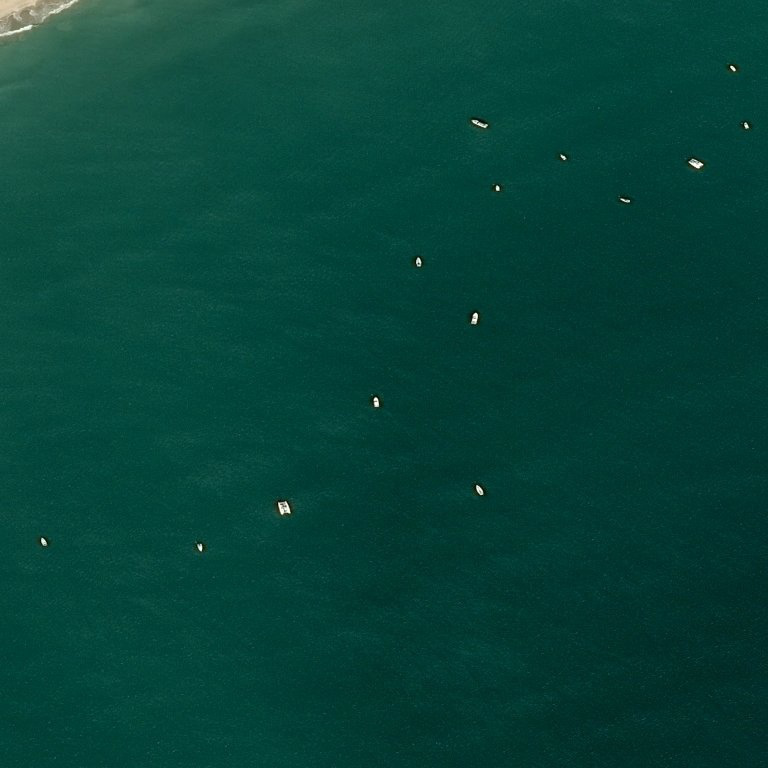

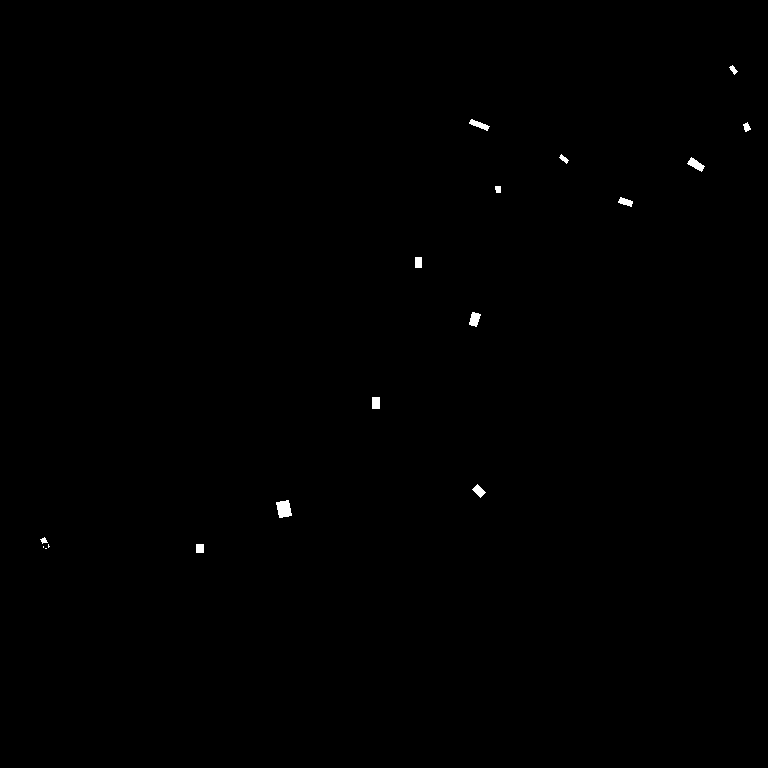

In [73]:
from IPython.display import display

# print(df_u[df_u['Shipnum']==15])

img = Image.open('train/02776139a.jpg')
display(img)

img1 = Image.fromarray(rle_decode('02776139a.jpg')*255)
display(img1)

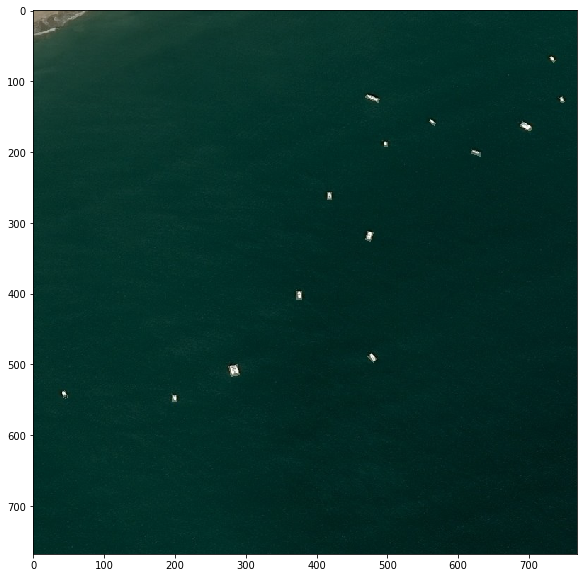

In [87]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(img1, cmap='gray', alpha=0.3)

In [0]:
# !rm -rf mask

if not os.path.exists('mask'):
  os.makedirs('mask')

for name in balanced_train_df['ImageId']:
    img = Image.fromarray(rle_decode(name))
    img.save('mask/'+name, 'JPEG')

for name in test_df['ImageId']:
    img = Image.fromarray(rle_decode(name))
    img.save('mask/'+name, 'JPEG')

In [0]:
train_datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.01, brightness_range=(0.8, 1.2), 
                                   zoom_range=0.1, fill_mode='reflect', horizontal_flip=True, vertical_flip=True)

mask_train_datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.01, 
                                        zoom_range=0.1, fill_mode='reflect', horizontal_flip=True, vertical_flip=True)

test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

bs = 64
SEED = 7

train_generator = train_datagen.flow_from_dataframe(dataframe=balanced_train_df, directory='train', x_col='ImageId', 
                                                    target_size=(image_height, image_width), batch_size=bs, class_mode=None, seed=SEED)

mask_train_generator = mask_train_datagen.flow_from_dataframe(dataframe=balanced_train_df, directory='mask', x_col='ImageId', 
                                                    target_size=(image_height, image_width), color_mode='grayscale', batch_size=bs, class_mode=None, seed=SEED)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory='train', x_col='ImageId', 
                                                    target_size=(image_height, image_width), batch_size=test_df.shape[0], class_mode=None)

mask_test_generator = mask_test_datagen.flow_from_dataframe(dataframe=test_df, directory='mask', x_col='ImageId', 
                                                    target_size=(image_height, image_width), color_mode='grayscale', batch_size=test_df.shape[0], class_mode=None)

TRAIN_GENERATOR = zip(train_generator, mask_train_generator)
TEST_GENERATOR = zip(test_generator, mask_test_generator)

x_train, y_train = next(TRAIN_GENERATOR)
print(x_train.shape, y_train.shape)

fig1 = plt.figure(figsize=(15, 15))
for i in range(1, 17):
  fig1.add_subplot(4, 4, i)
  plt.imshow(x_train[i].astype(int))

print(y_train[4].min(), y_train[4].max())
plt.show()

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epoch_num = 100

history = model.fit_generator(train_generator, steps_per_epoch=train_df.shape[0]//bs, epochs=epoch_num, 
                              validation_data=test_generator, callbacks=[mc])